In [155]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

# Disable specific package warnings if needed
np.seterr(all='ignore')  # Numpy warnings
pd.options.mode.chained_assignment = None  # Pandas warnings

rng = np.random.default_rng()

### Loads Data

In [97]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df.head()

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525


### Adds Cluster Column

In [98]:
def assign_cluster(row):
    """We assign a given observation to cluster 1 if pos_money < 0,
    else we assign to cluster 2"""
    if row['pos_money'] < 0:
        return 1
    else:
        return 2

# Apply the function row-wise
df['cluster'] = df.apply(assign_cluster, axis=1)
df.head()

,pos_money,neg_money,cluster
0,380,-500,2
1,340,-500,2
2,400,-550,2
3,400,-550,2
4,400,-525,2


### Empirical Starting Moneyline Distribution

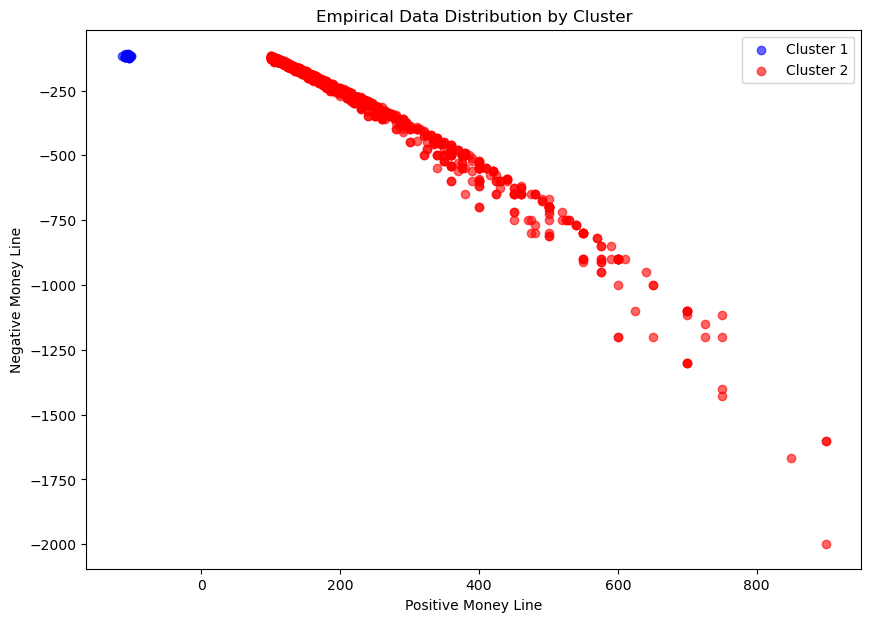

In [99]:
plt.figure(figsize=(10, 7))
for cluster, group in df.groupby('cluster'):
    if cluster == 1:
        color = 'blue'
        label = 'Cluster 1'
    else:
        color = 'red'
        label = 'Cluster 2'
    plt.scatter(group['pos_money'], group['neg_money'], label=label, color=color, alpha=0.6)
plt.title('Empirical Data Distribution by Cluster')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


# Classical Generative Model

1. Calculate p for falling in Cluster 1 (Gaussian) or Cluster 2 (Linear)
2. Generate Bernoulli(p)
3. If Cluster 1:
    * Sample from bivariate gaussian with mean and cov equal to the empirical metrics
4. If Cluster 2:
    * Use beta dist to sample pos_moneyline (find MLE estimate for params given the data)
    * Fit least squares model 1 for residuals (models heteroscedasticity
    * Fit least squares model 2 to data
    * Add residuals to generated y value when sampling

In [133]:
class StatGenModel:
    """
    A statistical model that generates parameters based on empirical data.
    
    Attributes:
        emp_data (pd.DataFrame): The original data.
        c1_data (np.ndarray): Numpy array of data for cluster 1.
        c2_data (np.ndarray): Numpy array of data for cluster 2.
        c1_params (dict): Dictionary containing parameters (mean and covariance) for cluster 1.
    """
    
    def __init__(self):
        """
        Initialize the StatGenModel with a DataFrame containing a 'cluster' column.
        """
        self.emp_data = None
        self.c1_data = None
        self.c2_data = None
        self.c1_params = None
        self.c2_params = None

    def fit(self, data):
        # Ensure that the 'cluster' column exists
        if 'cluster' not in data.columns:
            raise ValueError("Data must contain a 'cluster' column.")
     
        self.c1_data = data[data['cluster'] == 1].drop(['cluster'], axis=1).to_numpy()
        self.c2_data = data[data['cluster'] == 2].drop(['cluster'], axis=1).to_numpy()
        self.c1_params = self.fit_c1_params()
    
    
    def fit_c1_params(self):
        """
        Calculate the mean and covariance matrix for cluster 1 data.
        Returns:
            dict: A dictionary with keys 'mu' and 'sigma'.
        """
        mu = self.c1_data.mean(axis=0)
        sigma = np.cov(self.c1_data, rowvar=False)
        return {'mu': mu, 'sigma': sigma}

    def plot_clusters(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Plot Cluster 1 on the first axis
        ax1.scatter(self.c1_data[:, 0], self.c1_data[:, 1], color='blue', alpha=0.7)
        ax1.set_title("Scatter Plot of Cluster 1")
        ax1.set_xlabel("Positive Moneyline")
        ax1.set_ylabel("Negative Moneyline")
        
        # Plot Cluster 2 on the second axis
        ax2.scatter(self.c2_data[:, 0], self.c2_data[:, 1], color='red', alpha=0.7)
        ax2.set_title("Scatter Plot of Cluster 2")
        ax2.set_xlabel("Positive Moneyline")
        ax2.set_ylabel("Negative Moneyline")
        
        plt.tight_layout()
        plt.show()


    def generate_c1(self, size = 1000)
        data = rng.multivariate_normal(self.c1_params['mu'], self.c1_params['sigma'], size=size)

        


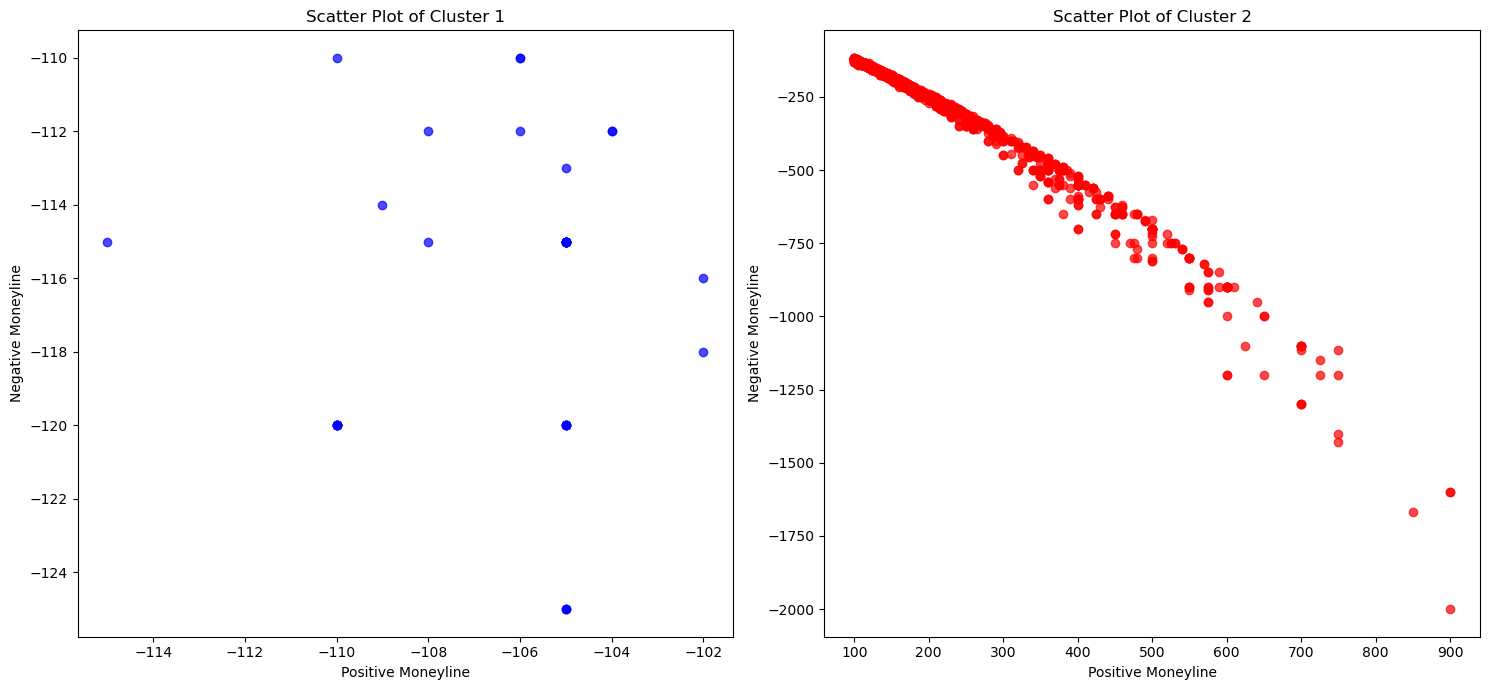

In [134]:
m1 = StatGenModel()
m1.fit(df)
m1.plot_clusters()b

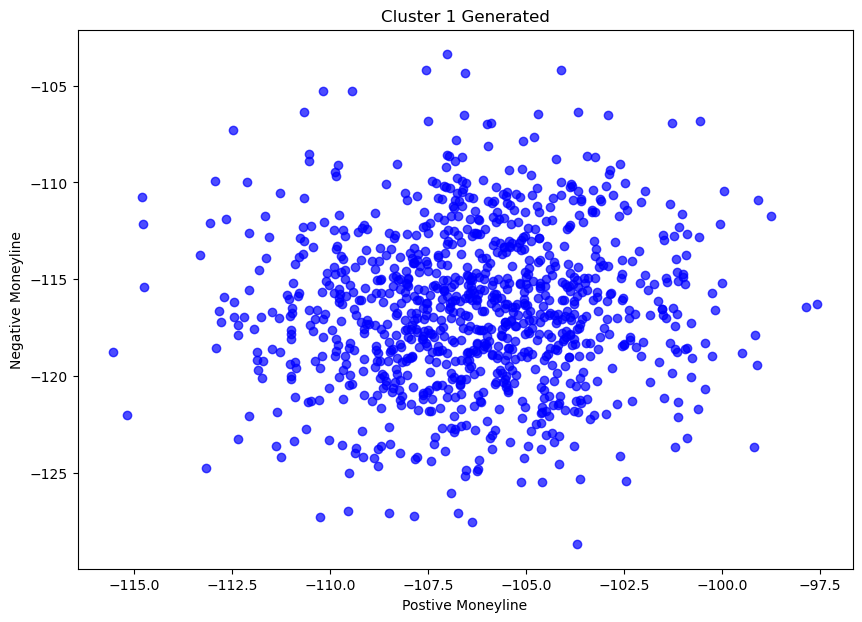

In [154]:



plt.figure(figsize=(10, 7))
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.7)
plt.title("Cluster 1 Generated")
plt.xlabel("Postive Moneyline")
plt.ylabel("Negative Moneyline")
plt.show()